In [13]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
#so we'll not get a new window for plots. everything will be in jupyter notebook
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [14]:
#study the trend and predict passengers for next 10yrs
dataset = pd.read_csv("AirPassengers.csv")
#parse string to datetime type
dataset['TravelDate'] = pd.to_datetime(dataset['TravelDate'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['TravelDate'])

In [15]:
dataset.drop([0])

,TravelDate,Passengers
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
5,1949-06-01,135
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


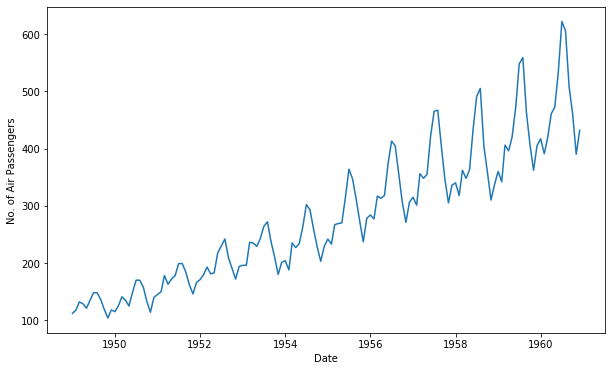

In [16]:
plt.xlabel("Date")
plt.ylabel("No. of Air Passengers")
plt.plot(indexedDataset)

In [17]:
#now check the stationarity
#we see that the data is not stationary, i.e., mean is not constant

#Determing rolling stats - 1st variety of test to check stationarity
rolmean = indexedDataset.rolling(window=12).mean()
rolstd  = indexedDataset.rolling(window=12).std()

print(rolmean,rolstd)

            Passengers
TravelDate            
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
TravelDate            
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


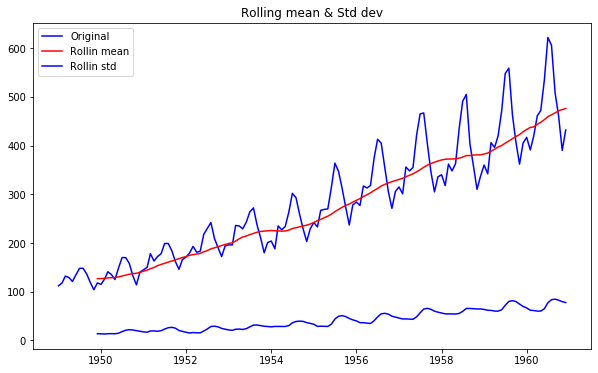

In [18]:
#now plot rolling stats
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean,color='red', label='Rollin mean' )
std = plt.plot(rolstd, color='b', label='Rollin std' )
plt.legend(loc='best')
plt.title('Rolling mean & Std dev')
plt.show()
#mean and std dev are not stationary

In [19]:
#Perform Dickey-fuller test as well
from statsmodels.tsa.stattools import adfuller

#AIC gives exact values and actual values and gives comparison values btwn them
#we have a huge p values, generally it should be 0.5 or less
#Also critical value should be more than the test statistic
#Data is NOT stationary
print('Result of Dickey fuller test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#lags used','no of observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical value (%s)'%key] = value

print(dfoutput)

Result of Dickey fuller test:
Test Statistic               0.815369
p-value                      0.991880
#lags used                  13.000000
no of observations used    130.000000
Critical value (1%)         -3.481682
Critical value (5%)         -2.884042
Critical value (10%)        -2.578770
dtype: float64


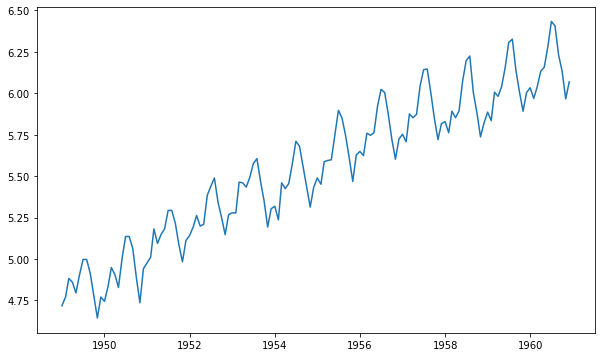

In [22]:
#estimating trend
#just consider log of indexeddataset, therefore nos on Y Axis have changed
indexedDataset_logscale=np.log(indexedDataset)
plt.plot(indexedDataset_logscale)

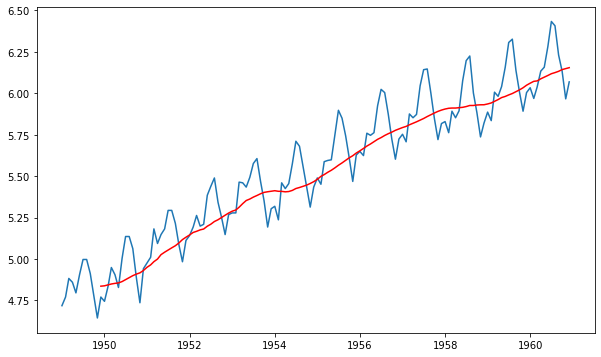

In [24]:
#calc MA with log time series
movingaverage = indexedDataset_logscale.rolling(window=12).mean()
movingSTD = indexedDataset_logscale.rolling(window=12).std()
#plt.plot(indexedDataset_logrolling)
plt.plot(indexedDataset_logscale)
plt.plot(movingaverage, color='red')

In [25]:
#get the difference btwn MA and actual no of passengers
#unless we perform all these transformations we'll not get TS to be stationary
#This is NOT a std way. There are many ways to do it.
datasetlogscaleminusmovingavg = indexedDataset_logscale - movingaverage
datasetlogscaleminusmovingavg.head(5)

,Passengers
TravelDate,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [26]:
#remove nan values
datasetlogscaleminusmovingavg.dropna(inplace=True)
datasetlogscaleminusmovingavg.head(5)

,Passengers
TravelDate,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


In [27]:
#we're performing this to see if TS is stationary or not
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    
    #Determining rolling stats
    movingaverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling stats
    orig = plt.plot(timeseries, color='blue', label='original')
    mean = plt.plot(movingaverage, color='red', label='rolling mean')
    std = plt.plot(movingSTD, color='black',label='std dev')
    plt.legend(loc='best')
    plt.title('Rolling mean & Std dev')
    plt.show()
    
    #Dickey Fuller test
    print('Result of Dickey fuller test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#lags used','no of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
    print(dfoutput)
    

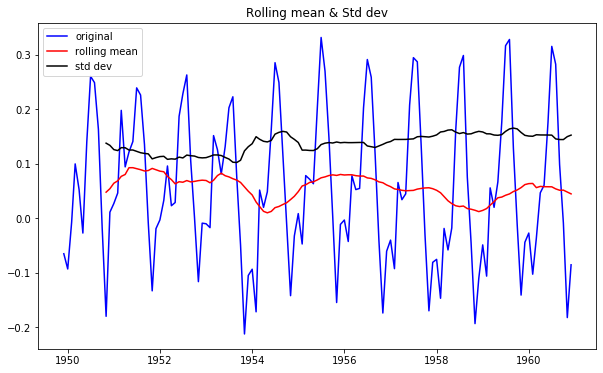

Result of Dickey fuller test:
Test Statistic              -3.162908
p-value                      0.022235
#lags used                  13.000000
no of observations used    119.000000
Critical value (1%)         -3.486535
Critical value (5%)         -2.886151
Critical value (10%)        -2.579896
dtype: float64


In [28]:
#here we see that the p value has decreased from 0.99 to 0.02
test_stationary(datasetlogscaleminusmovingavg)

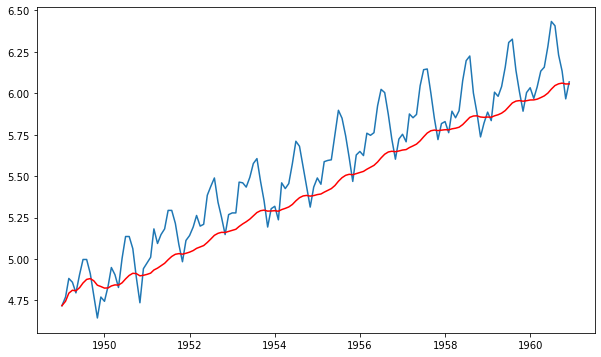

In [29]:
#now we calculate the weighted avg in TS, to see the trend
#we see upward trend
exponentialdecaywtdavg = indexedDataset_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logscale)
plt.plot(exponentialdecaywtdavg, color='red')

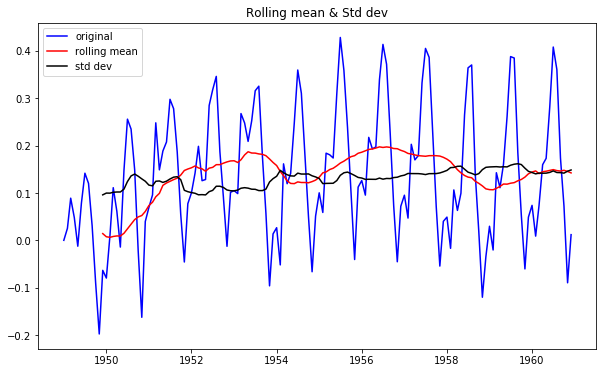

Result of Dickey fuller test:
Test Statistic              -3.601262
p-value                      0.005737
#lags used                  13.000000
no of observations used    130.000000
Critical value (1%)         -3.481682
Critical value (5%)         -2.884042
Critical value (10%)        -2.578770
dtype: float64


In [30]:
#here we remove the weighted avg,, to check for stationarity
datasetlogscaleminusmovexpodecayavg = indexedDataset_logscale - exponentialdecaywtdavg
test_stationary(datasetlogscaleminusmovexpodecayavg)

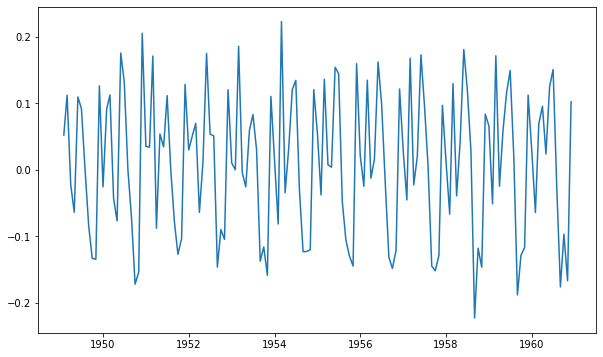

In [31]:
datasetlogdiffshifting = indexedDataset_logscale - indexedDataset_logscale.shift()
plt.plot(datasetlogdiffshifting)

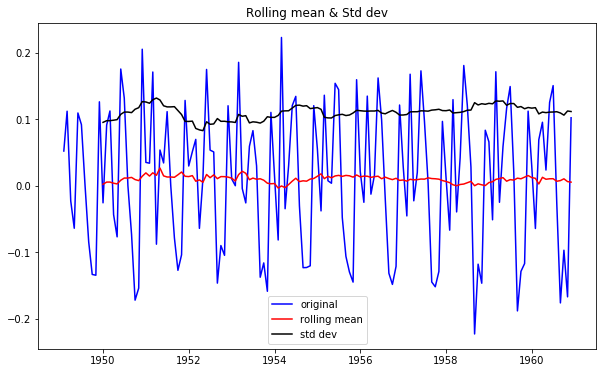

Result of Dickey fuller test:
Test Statistic              -2.717131
p-value                      0.071121
#lags used                  14.000000
no of observations used    128.000000
Critical value (1%)         -3.482501
Critical value (5%)         -2.884398
Critical value (10%)        -2.578960
dtype: float64


In [32]:
datasetlogdiffshifting.dropna(inplace=True)
test_stationary(datasetlogdiffshifting)

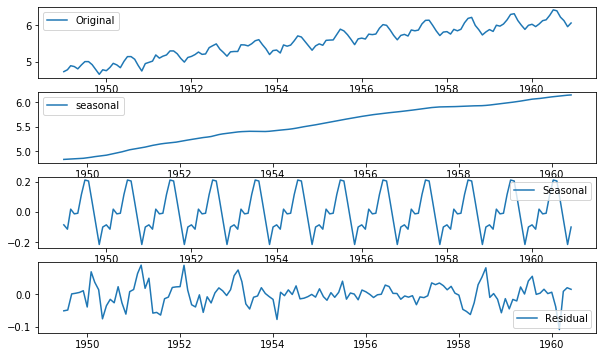

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logscale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='seasonal')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

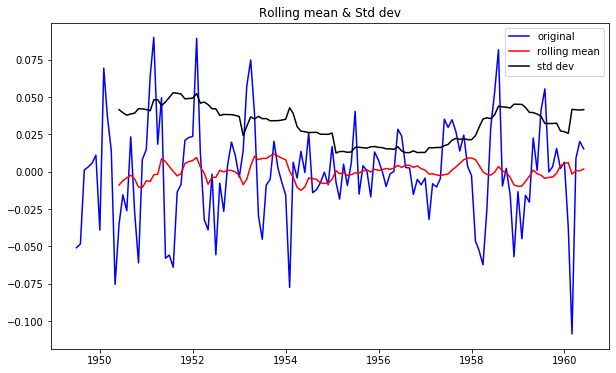

Result of Dickey fuller test:
Test Statistic            -6.332387e+00
p-value                    2.885059e-08
#lags used                 9.000000e+00
no of observations used    1.220000e+02
Critical value (1%)       -3.485122e+00
Critical value (5%)       -2.885538e+00
Critical value (10%)      -2.579569e+00
dtype: float64


In [34]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationary(decomposedLogData)

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


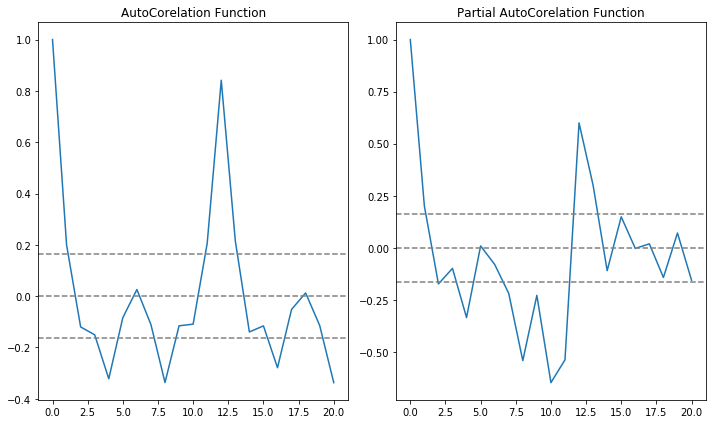

In [35]:
#ACF and PACF model
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetlogdiffshifting, nlags=20)
lag_pacf = pacf(datasetlogdiffshifting, nlags=20, method='ols')

#PLOT ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.title('AutoCorelation Function')

#PLOT PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
plt.title('Partial AutoCorelation Function')
plt.tight_layout()

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR Model


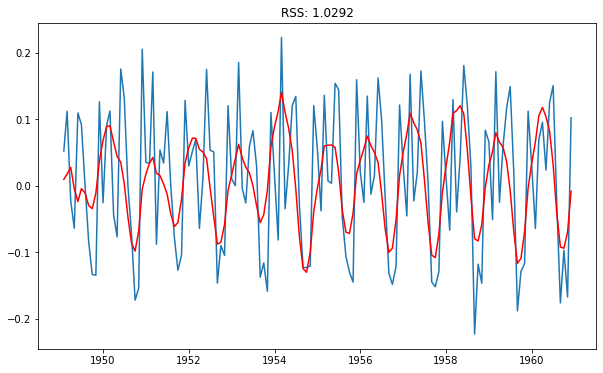

In [36]:
from statsmodels.tsa.arima_model import ARIMA
#AR is coreln btwn previous time period to current
#AR Model
model = ARIMA(indexedDataset_logscale, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetlogdiffshifting['Passengers'])**2))
print('Plotting AR Model')

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA Model


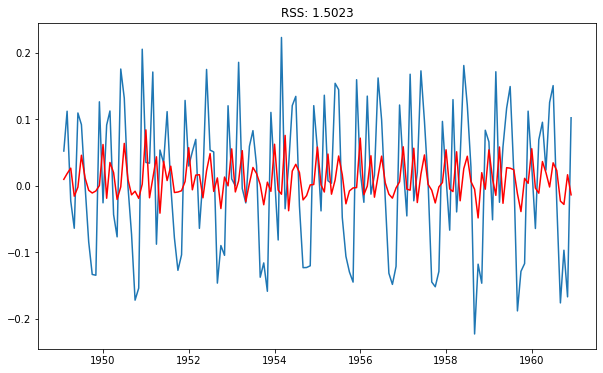

In [37]:
#there is always some noise and we need to find out the avg of that noise
#when we try to avg, the crust and trough present smoothen out and we have avg of it
#MA Model
model = ARIMA(indexedDataset_logscale, order=(2,1,0))
results_MA = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetlogdiffshifting['Passengers'])**2))
print('Plotting MA Model')

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

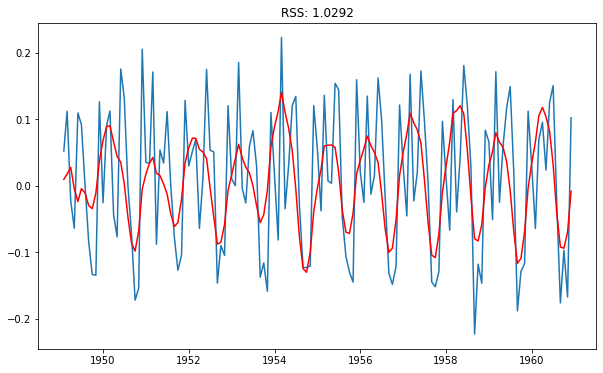

In [38]:
model = ARIMA(indexedDataset_logscale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetlogdiffshifting['Passengers'])**2))

In [39]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

TravelDate
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [40]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

TravelDate
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [41]:
#predictions_ARIMA_log = pd.Series(indexedDataset_logscale['Passengers'].ix[0], indexedDataset_logscale.index)
predictions_ARIMA_log = pd.Series(indexedDataset_logscale['Passengers'].iloc[0], indexedDataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

TravelDate
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

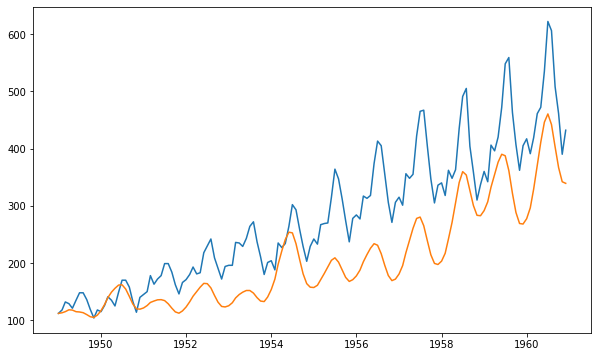

In [42]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [43]:
indexedDataset_logscale

,Passengers
TravelDate,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


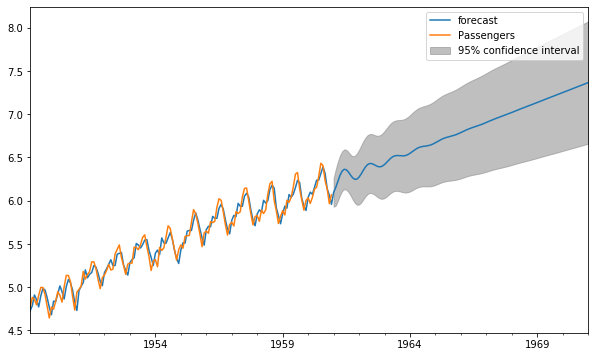

In [44]:
results_ARIMA.plot_predict(1,264)
x=results_ARIMA.forecast(steps=120)

In [45]:
x[1]

array([0.08384711, 0.10749462, 0.11568695, 0.11702775, 0.11703497,
       0.11744018, 0.1176225 , 0.11778713, 0.12024163, 0.12736042,
       0.13870959, 0.15118792, 0.16157813, 0.16834393, 0.17177328,
       0.17311981, 0.17358731, 0.17385458, 0.17430216, 0.1754333 ,
       0.17788146, 0.18195721, 0.18726216, 0.19283392, 0.19769243,
       0.20130638, 0.20369054, 0.20519831, 0.20625268, 0.20720998,
       0.2083697 , 0.21000326, 0.21229744, 0.21524478, 0.21860179,
       0.22198256, 0.22503064, 0.22755294, 0.22954806, 0.23114797,
       0.23253825, 0.23390534, 0.2354131 , 0.23718312, 0.23926538,
       0.24161538, 0.24410371, 0.24656357, 0.24885256, 0.25089629,
       0.25269733, 0.25431628, 0.25584312, 0.25737228, 0.2589839 ,
       0.2607285 , 0.26261548, 0.2646109 , 0.26664898, 0.26865481,
       0.27056849, 0.27236097, 0.27403701, 0.27562774, 0.27717829,
       0.27873527, 0.28033591, 0.28200018, 0.28372683, 0.2854951 ,
       0.28727211, 0.28902345, 0.29072337, 0.29236083, 0.29394

In [46]:
len(x[1])

120

In [47]:
np.exp(x[1])

array([1.08746262, 1.11348487, 1.12264437, 1.12415063, 1.12415874,
       1.12461435, 1.12481941, 1.12500461, 1.12776932, 1.13582632,
       1.14879044, 1.16321523, 1.17536428, 1.18334353, 1.18740859,
       1.18900855, 1.18956454, 1.18988252, 1.19041521, 1.1917625 ,
       1.1946837 , 1.19956286, 1.2059434 , 1.21268137, 1.21858754,
       1.22299942, 1.22591872, 1.22776852, 1.22906372, 1.23024087,
       1.23166844, 1.23368208, 1.23651561, 1.24016543, 1.24433567,
       1.2485496 , 1.25236109, 1.25552391, 1.25803133, 1.26004568,
       1.26179871, 1.26352488, 1.26543141, 1.26767323, 1.27031561,
       1.27330436, 1.2764767 , 1.27962052, 1.28255292, 1.28517679,
       1.28749353, 1.28957961, 1.29155009, 1.29352659, 1.29561295,
       1.29787524, 1.30032662, 1.3029239 , 1.30558209, 1.30820348,
       1.31070936, 1.31306089, 1.31526348, 1.31735737, 1.31940159,
       1.32145747, 1.32357435, 1.32577896, 1.32807009, 1.33042056,
       1.33278683, 1.33512304, 1.33739457, 1.3395863 , 1.34170